<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Проверяю-данные-на-наличие-пропусков" data-toc-modified-id="Проверяю-данные-на-наличие-пропусков-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Проверяю данные на наличие пропусков</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Строю-график-скользящего-среднего-с-окном,-равным-7,-и-график-о-заказах-такси-в-аэропортах-(с-ресемплированием-в-1-день)." data-toc-modified-id="Строю-график-скользящего-среднего-с-окном,-равным-7,-и-график-о-заказах-такси-в-аэропортах-(с-ресемплированием-в-1-день).-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Строю график скользящего среднего с окном, равным 7, и график о заказах такси в аэропортах (с ресемплированием в 1 день).</a></span></li><li><span><a href="#Строю-график-сезонности" data-toc-modified-id="Строю-график-сезонности-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Строю график сезонности</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Запускаю-модель-линейной-регрессии" data-toc-modified-id="Запускаю-модель-линейной-регрессии-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Запускаю модель линейной регрессии</a></span></li><li><span><a href="#Исследую-модель-случайного-леса" data-toc-modified-id="Исследую-модель-случайного-леса-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Исследую модель случайного леса</a></span></li><li><span><a href="#Исследую-модель-LightGBM" data-toc-modified-id="Исследую-модель-LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Исследую модель LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
display(df.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Проверяю данные на наличие пропусков

In [5]:
df.isna().sum()

num_orders    0
dtype: int64

В столбце rolling_mean обнаружены пропуски. Пропусков всего шесть, их удаление не скажется на качестве данных, поэтому просто удаляю пропуски

In [6]:
df = df.dropna()
df.isna().sum()

num_orders    0
dtype: int64

Выполняю ресемплирование по 1 часу

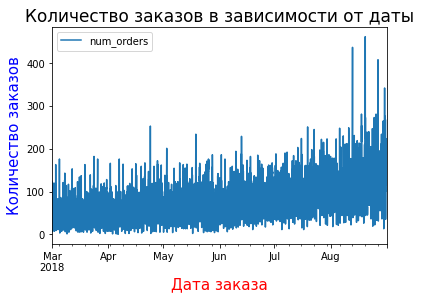

In [7]:
df = df.resample('1H').sum()
df.plot()
plt.ylabel('Количество заказов', fontsize=15, color='blue')
plt.xlabel('Дата заказа', fontsize=15, color='red')
plt.title('Количество заказов в зависимости от даты', fontsize=17);

## Анализ

### Строю график скользящего среднего с окном, равным 7, и график о заказах такси в аэропортах (с ресемплированием в 1 день).

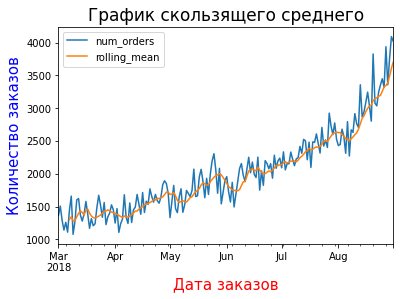

In [8]:
df.sort_index(inplace=True)
df_3 = df.resample('1D').sum()
df_rolling = df_3.resample('1D').sum()
df_rolling['rolling_mean'] = df_3.rolling(7).mean()
df_rolling.plot()
plt.ylabel('Количество заказов', fontsize=15, color='blue')
plt.xlabel('Дата заказов', fontsize=15, color='red')
plt.title('График скользящего среднего', fontsize=17);

Количество заказов с марта по август увеличивается

### Строю график сезонности

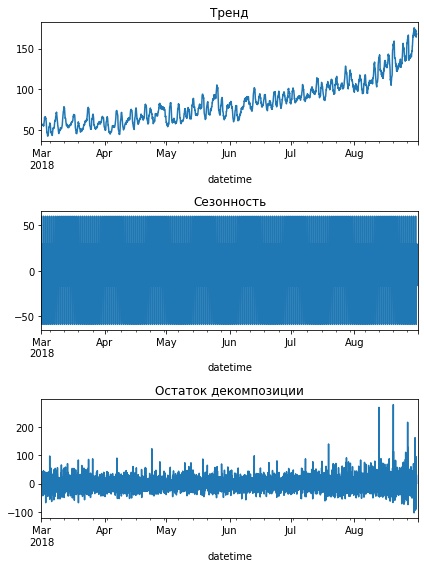

In [9]:
df.sort_index(inplace=True)
df_hour = df.resample('1H').sum()

decomposed = seasonal_decompose(df_hour)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток декомпозиции')
plt.tight_layout()

Попробовала построить график сезонности, ресемплировав по 1 часу. График получился не очень наглядный, поэтому ниже пробую ресемплировать по 1 дню.

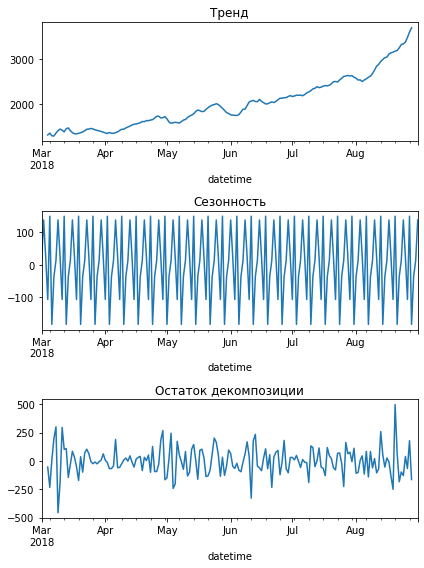

In [10]:
df.sort_index(inplace=True)
df_day = df.resample('1D').sum()

decomposed = seasonal_decompose(df_day)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток декомпозиции')
plt.tight_layout()

Опять не очень наглядно получилось. Пробую построить график сезонности за 1 месяц. За март 2018 года.

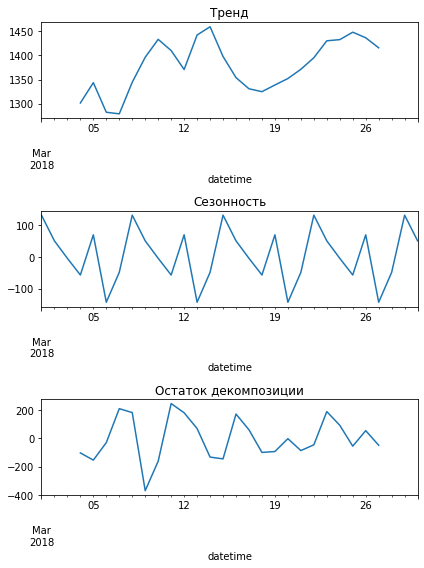

In [11]:
df.sort_index(inplace=True)
df_march = df['2018-03-01':'2018-03-30'].resample('1D').sum()

decomposed = seasonal_decompose(df_march)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток декомпозиции')
plt.tight_layout()

Из графиков видно, что пик заказов случается 10, 13-14 марта и 25 марта.\
Также из графиков видно, что максимальное количество заказов приходится на четверг каждой недели.

## Обучение

Пишу функцию, чтобы прибавить к таблице календарные признаки, максимальный размер отставания и скользящее среднее

In [12]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

Подбираю аргументы функции make_features, чтобы достичь оптимального значения RMSE

In [13]:
make_features(df, 168, 168)

In [14]:
df.head(5)

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разбиваю данные на тренировочные, валидационные и тестовые

In [15]:
train, valid = train_test_split(df, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid, shuffle=False, test_size=0.5)
train = train.dropna()

target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)

target_valid = valid['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)

target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)

In [16]:
features_train.shape

(3364, 171)

In [17]:
target_train.shape

(3364,)

### Запускаю модель линейной регрессии

In [18]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)

result = mean_squared_error(target_valid, predictions_valid)**0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result)

RMSE модели линейной регрессии на валидационной выборке: 28.080614552064187


### Исследую модель случайного леса

In [19]:
%%time

best_model = None
best_result = 50
for est in range(1, 7):
    for depth in range(1, 7):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = mean_squared_error(target_valid, predictions_valid)**0.5
        if result < best_result:
            best_model = model
            best_result = result

print("RMSE наилучшей модели на валидационной выборке:", best_result)
print ("Какие гиперпараметры дали наилучший результат:", best_model)

RMSE наилучшей модели на валидационной выборке: 31.433357885516443
Какие гиперпараметры дали наилучший результат: RandomForestRegressor(max_depth=6, n_estimators=6, random_state=12345)
CPU times: user 10.2 s, sys: 72.6 ms, total: 10.3 s
Wall time: 10.6 s


### Исследую модель LightGBM

In [20]:
%%time


features_train_lgb = lgb.Dataset(features_train, label=None 
                                )
features_valid_lgb = lgb.Dataset(features_valid, label=None
                                )
target_valid_lgb = lgb.Dataset(target_valid)

params = {'objective': 'regression'}

model_lgb = lgb.train(params,
                 train_set=features_train_lgb,
                 valid_sets=features_valid_lgb,
                 num_boost_round=10)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29597
[LightGBM] [Info] Number of data points in the train set: 3364, number of used features: 171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l2: 0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid_0's l2: 0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[3]	valid_0's l2: 0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped traini

In [21]:
predictions_valid = model_lgb.predict(features_valid, pred_leaf=True)
result = mean_squared_error(target_valid, predictions_valid)**0.5
print("RMSE модели на валидационной выборке:", result)

RMSE модели на валидационной выборке: 119.31087004295644


Наименьшее значение RMSE показала модель линейной регрессии. Тестирую ее.

## Тестирование

Объединяю тренировочные и валидационные данные

In [22]:
features_train_valid = pd.concat([features_train, features_valid])
target_train_valid = pd.concat([target_train, target_valid])
print (features_train_valid.shape)
print (target_train_valid.shape)

(3806, 171)
(3806,)


In [23]:
model = LinearRegression()
model.fit(features_train_valid, target_train_valid)
predictions_test = model.predict(features_test)

result = mean_squared_error(target_test, predictions_test)**0.5
print("RMSE модели линейной регрессии на тестовой выборке:", result)

RMSE модели линейной регрессии на тестовой выборке: 34.94576697919462


## Вывод

Задачей данного проекта было прогнозирование количества заказов такси на следующий час на основе исторических данных для заказа такси в аэропортах для привлечения большего количества водителей в периоды пиковой нагрузки. 

Для выполнения проекта я сделала:
* Загрузила данные и выполнила их ресемплирование по одному часу.
* Проанализировала данные.
* Обучить модели: линейной регрессии, случайного леса, LightGBM.
Наилучший результат на валидационной выборке показала модель линейной регрессии.

Проверила данную модель на тестовой выборке.